In [1]:
import cv2
import numpy as np
from cellmask_model import CellMaskModel
import os
import matplotlib.pyplot as plt
from data import import_images

c:\Users\rz200\Anaconda3\envs\cellenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
def get_encFeats_flat(model,image,type='cp'):
    pad_val = model.expand_div_256(image)[1]
    cp, mask, instance_mask, encFeats_cp, encFeats_mask = model.get_pred(image,0,encFeats=True)

    if type=='cp':
        encFeats = encFeats_cp
    elif type=='mask':
        encFeats = encFeats_mask

    encFeats_arr = []
    for enc in encFeats:
        arr = enc.detach()
        arr = np.expand_dims(arr,0)
        arr = np.expand_dims(arr,0)
        encFeats_arr.append(arr)

    stacked = model.stack_img(encFeats_arr,colrow=64)
    res = cv2.resize(stacked, dsize=(1280, 1280), interpolation=cv2.INTER_CUBIC)
    res = res[pad_val:-pad_val, pad_val:-pad_val]
    return res, instance_mask

def get_encFeats_flat_from_pred(instance_mask,encFeats,type='cp'):
    model = CellMaskModel()
    pad_val = model.expand_div_256(instance_mask)[1]

    encFeats_arr = []
    for enc in encFeats:
        arr = enc.detach()
        arr = np.expand_dims(arr,0)
        arr = np.expand_dims(arr,0)
        encFeats_arr.append(arr)

    stacked = model.stack_img(encFeats_arr,colrow=64)
    res = cv2.resize(stacked, dsize=(1280, 1280), interpolation=cv2.INTER_CUBIC)
    res = res[pad_val:-pad_val, pad_val:-pad_val]

    return res, instance_mask

def get_centers_of_ROIs(instance_mask):
    centers_instance_mask = []
    for i in range(1,max(instance_mask.flatten())+1):
        cell =  np.array(np.where(instance_mask == i,1,0))
        M = cv2.moments(np.float32(cell))
        center = (int(M["m10"] / M["m00"]),int(M["m01"] / M["m00"]))
        centers_instance_mask.append(center)
    return centers_instance_mask

def get_instance_encFeats_from_img(model,image,type='cp'):
    encFeats_flat, instance_mask = get_encFeats_flat(model,image,type=type)

    instance_encFeats = []
    for i in range(1,max(instance_mask.flatten())+1):
        instance_encFeats.append(np.delete(encFeats_flat,np.where(instance_mask.flatten()!=i)))

    cell_centers = get_centers_of_ROIs(instance_mask)
    return np.array(instance_encFeats), cell_centers

def get_instance_encFeats_from_encFeats(encFeats_flat,instance_mask,type='cp'):
    instance_encFeats = []
    for i in range(1,max(instance_mask.flatten())+1):
        first = instance_mask.flatten()
        second = encFeats_flat.flatten()
        mask = first == i
        rn = np.take(second, np.where(mask)[0])
        rn = np.extract(rn != 0, rn)
        instance_encFeats.append(rn)

    cell_centers = get_centers_of_ROIs(instance_mask)
    return np.array(instance_encFeats), cell_centers

def resize_arrays_to_fit_another(arrays_to_resize,array):
    arrays_shaped = []
    for i in arrays_to_resize:
        if i.shape < array.shape:
            pad_by = array.shape[0]-i.shape[0]
            new_arr = np.pad(i, (0, pad_by), 'constant')
            arrays_shaped.append(new_arr)
        elif i.shape > array.shape:
            arrays_shaped.append(i[:array.shape[0]])
        else:
            arrays_shaped.append(i)
    arrays_shaped = np.array(arrays_shaped)
    return arrays_shaped

def get_distance_between_cells(initial_cell_center,all_cell_centers):
    center_distances = []
    a = np.array(initial_cell_center)
    for cell_center in all_cell_centers:
        b = np.array(cell_center)
        center_distances.append(np.linalg.norm(a-b))
    return center_distances

def get_matching_cells(initial_cell,all_cells,cell_distances,radius=1000):
    all_cells_shaped = resize_arrays_to_fit_another(all_cells,initial_cell)
    cos_sim = np.dot(initial_cell, all_cells_shaped.T)/(np.linalg.norm(all_cells_shaped)*np.linalg.norm(initial_cell))

    #use the radius to limit the possible cells,
    #maybe input into the function an array of all the cells but just their distance to the others
    cell_distances = np.array(cell_distances)
    possible_matches = np.where(cell_distances < radius,cos_sim,0)

    match_index = np.argmax(possible_matches)
    #return idnex of max value in possible_matches

    return match_index

def get_matching_cells_averaged_cp_mask(initial_cell_enc_cp, initial_cell_enc_mask, all_cells_enc_cp, all_cells_enc_mask, cell_distances, radius=1000):
    all_cells_enc_cp_shaped = resize_arrays_to_fit_another(all_cells_enc_cp,initial_cell_enc_cp)
    all_cells_enc_mask_shaped = resize_arrays_to_fit_another(all_cells_enc_mask,initial_cell_enc_mask)

    cos_sim_cp = np.dot(initial_cell_enc_cp, all_cells_enc_cp_shaped.T)/(np.linalg.norm(all_cells_enc_cp_shaped)*np.linalg.norm(initial_cell_enc_cp))
    cos_sim_mask = np.dot(initial_cell_enc_mask, all_cells_enc_mask_shaped.T)/(np.linalg.norm(all_cells_enc_mask_shaped)*np.linalg.norm(initial_cell_enc_mask))
    cos_sim_avg = (cos_sim_cp+cos_sim_mask)/2

    cell_distances = np.array(cell_distances)
    possible_matches = np.where(cell_distances < radius, cos_sim_avg, 0)
    match_index = np.argmax(possible_matches)

    return possible_matches



In [28]:
model = CellMaskModel()
model.import_model(os.getcwd() + '/saved_weights/cp_model', os.getcwd() + '/saved_weights/mask_model')

images_path_1059 = os.getcwd() + '/images_1059_0/'
images_1059 = import_images(images_path_1059,normalisation=True,num_imgs=5,format='.tiff')

In [ ]:
# Make a comparison with the amount of linalg so that we don't have multiple 

In [5]:
cps, masks, instance_masks, encFeats_cps, encFeats_masks = model.eval(images_1059,0,encFeats=True)

25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
25
(1, 1, 256, 256)


In [41]:
#0
encFeats_cp_flat_0, instance_mask_0 = get_encFeats_flat_from_pred(instance_masks[0],encFeats_cps[0]) #cp enc
encFeats_mask_flat_0, instance_mask_0 = get_encFeats_flat_from_pred(instance_masks[0],encFeats_masks[0]) #mask enc

instance_encFeats_cp_0, cell_centers_0 = get_instance_encFeats_from_encFeats(encFeats_cp_flat_0,instance_masks[0],type='cp')
instance_encFeats_mask_0, cell_centers_0 = get_instance_encFeats_from_encFeats(encFeats_mask_flat_0,instance_masks[0],type='mask')

#1
encFeats_cp_flat_1, instance_mask_1 = get_encFeats_flat_from_pred(instance_masks[1],encFeats_cps[1]) #cp enc
encFeats_mask_flat_1, instance_mask_1 = get_encFeats_flat_from_pred(instance_masks[1],encFeats_masks[1]) #mask enc

instance_encFeats_cp_1, cell_centers_1 = get_instance_encFeats_from_encFeats(encFeats_cp_flat_1,instance_masks[1],type='cp')
instance_encFeats_mask_1, cell_centers_1 = get_instance_encFeats_from_encFeats(encFeats_mask_flat_1,instance_masks[1],type='mask')

#get_matching_cells_averaged_cp_mask(initial_cell_enc_cp, initial_cell_enc_mask, all_cells_enc_cp, all_cells_enc_mask, cell_distances,radius=1000)

distance_between_cells_from_first = get_distance_between_cells(cell_centers_0[0],cell_centers_1)
match = get_matching_cells_averaged_cp_mask(instance_encFeats_cp_0[0], instance_encFeats_mask_0[0], instance_encFeats_cp_1, instance_encFeats_mask_1, distance_between_cells_from_first, radius=100)


C:\Users\rz200\AppData\Local\Temp\ipykernel_11324\1273650768.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(instance_encFeats), cell_centers


In [47]:
distance_between_cells_from_first = get_distance_between_cells(cell_centers_0[0],cell_centers_1)
match = get_matching_cells_averaged_cp_mask(instance_encFeats_cp_0[0], instance_encFeats_mask_0[0], instance_encFeats_cp_1, instance_encFeats_mask_1, distance_between_cells_from_first, radius=400)
print(max(np.unique(match)))

0.06560006


In [52]:
#make the above a function

def get_both_encfeats(model,images):
    cps, masks, instance_masks, encFeats_cps, encFeats_masks = model.eval(images,0,encFeats=True)
    
    instance_encFeats_cps = []
    instance_encFeats_masks = []
    distance_between_cells  = []

    for i in range(len(instance_masks)-1):
        print(i)
        encFeats_cp_flat_0, instance_mask_0 = get_encFeats_flat_from_pred(instance_masks[i],encFeats_cps[i]) #cp enc
        instance_encFeats_cp, cell_centers_0 = get_instance_encFeats_from_encFeats(encFeats_cp_flat_0,instance_masks[i],type='cp')
        instance_encFeats_cps.append(instance_encFeats_cp)

        encFeats_mask_flat_0, instance_mask_0 = get_encFeats_flat_from_pred(instance_masks[i],encFeats_masks[i]) #mask enc
        instance_encFeats_mask_0, cell_centers_0 = get_instance_encFeats_from_encFeats(encFeats_mask_flat_0,instance_masks[i],type='mask')
        instance_encFeats_masks.append(instance_encFeats_mask_0)

        distance_between_each_cells_and_next_img = []
        cell_centers_next_img = get_centers_of_ROIs(instance_masks[i+1])

        for j in range(len(cell_centers_0)):
            if j %20 == 0:
                print('j:',j)
            distance_between_each_cells_and_next_img.append(get_distance_between_cells(cell_centers_0[j],cell_centers_next_img))

        distance_between_cells.append(distance_between_each_cells_and_next_img)

    return instance_encFeats_cps, instance_encFeats_masks, distance_between_cells

instance_encFeats_cps, instance_encFeats_masks, distance_between_cells = get_both_encfeats(model,images_1059)

def get_possible_matches(instance_masks,encFeats_cps,encFeats_masks):

    encFeats_cp_flat_0, instance_mask_0 = get_encFeats_flat_from_pred(instance_masks[0],encFeats_cps[0]) #cp enc
    encFeats_mask_flat_0, instance_mask_0 = get_encFeats_flat_from_pred(instance_masks[0],encFeats_masks[0]) #mask enc
    instance_encFeats_cp_0, cell_centers_0 = get_instance_encFeats_from_encFeats(encFeats_cp_flat_0,instance_masks[0],type='cp')
    instance_encFeats_mask_0, cell_centers_0 = get_instance_encFeats_from_encFeats(encFeats_mask_flat_0,instance_masks[0],type='mask')

    encFeats_cp_flat_1, instance_mask_1 = get_encFeats_flat_from_pred(instance_masks[1],encFeats_cps[1]) #cp enc
    encFeats_mask_flat_1, instance_mask_1 = get_encFeats_flat_from_pred(instance_masks[1],encFeats_masks[1]) #mask enc
    instance_encFeats_cp_1, cell_centers_1 = get_instance_encFeats_from_encFeats(encFeats_cp_flat_1,instance_masks[1],type='cp')
    instance_encFeats_mask_1, cell_centers_1 = get_instance_encFeats_from_encFeats(encFeats_mask_flat_1,instance_masks[1],type='mask')

    distance_between_cells_from_first = get_distance_between_cells(cell_centers_0[0],cell_centers_1)
    possible_matches = get_matching_cells_averaged_cp_mask(instance_encFeats_cp_0[0], instance_encFeats_mask_0[0], instance_encFeats_cp_1, instance_encFeats_mask_1, distance_between_cells_from_first, radius=400)

    return possible_matches

#here we give the encFeat instances of two images to find all the possible matching cells from the first image to the second
# Input: instance encFeats first image, instance encFeats second image
# Output: list of list of the matches of each cells
def get_possible_matches_for_all_cells_in_image(instance_encFeats_cp, instance_encFeats_mask


25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
0


C:\Users\rz200\AppData\Local\Temp\ipykernel_11324\1273650768.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(instance_encFeats), cell_centers


j: 0
j: 20
j: 40
j: 60
j: 80
j: 100
j: 120
j: 140
j: 160
j: 180
1
j: 0
j: 20
j: 40
j: 60
j: 80
j: 100
j: 120
j: 140
j: 160
j: 180
2
j: 0
j: 20
j: 40
j: 60
j: 80
j: 100
j: 120
j: 140
j: 160
j: 180
j: 200
3
j: 0
j: 20
j: 40
j: 60
j: 80
j: 100
j: 120
j: 140
j: 160
j: 180
j: 200


In [201]:
cps, masks, instance_masks, encFeats_cps, encFeats_masks = model.eval(images_1059,0,encFeats=True)

encFeats_cp_flat_0, instance_mask_0 = get_encFeats_flat_from_pred(model,instance_masks[0],encFeats_cps[0])
encFeats_cp_flat_1, instance_mask_1 = get_encFeats_flat_from_pred(model,instance_masks[1],encFeats_cps[1])
encFeats_cp_flat_2, instance_mask_2 = get_encFeats_flat_from_pred(model,instance_masks[2],encFeats_cps[2])
encFeats_cp_flat_3, instance_mask_3 = get_encFeats_flat_from_pred(model,instance_masks[3],encFeats_cps[3])

instance_encFeats_0, cell_centers_0 = get_instance_encFeats_from_encFeats(encFeats_cp_flat_0,instance_masks[0],type='cp')
instance_encFeats_1, cell_centers_1 = get_instance_encFeats_from_encFeats(encFeats_cp_flat_1,instance_masks[1],type='cp')
instance_encFeats_2, cell_centers_2 = get_instance_encFeats_from_encFeats(encFeats_cp_flat_2,instance_masks[2],type='cp')
instance_encFeats_3, cell_centers_3 = get_instance_encFeats_from_encFeats(encFeats_cp_flat_3,instance_masks[3],type='cp')

matches_first_img = []
for i in range(1,np.max(instance_masks[0]+1)):
    distance_between_cells_from_first = get_distance_between_cells(cell_centers_0[i-1],cell_centers_1)
    match = get_matching_cells_averaged_cp_mask(instance_encFeats_cp_0[0], instance_encFeats_mask_0[0], instance_encFeats_cp_1, instance_encFeats_mask_1, distance_between_cells_from_first, radius=60)
    matches_first_img.append(match)

matches_second_img = []
for i in range(1,np.max(instance_masks[1]+1)):
    distance_between_cells_from_first = get_distance_between_cells(cell_centers_1[i-1],cell_centers_2)
    match = get_matching_cells(instance_encFeats_1[i-1],instance_encFeats_2,distance_between_cells_from_first,radius=60)
    matches_second_img.append(match)

matches_third_img = []
for i in range(1,np.max(instance_masks[2]+1)):
    distance_between_cells_from_first = get_distance_between_cells(cell_centers_2[i-1],cell_centers_3)
    match = get_matching_cells(instance_encFeats_2[i-1],instance_encFeats_3,distance_between_cells_from_first,radius=60)
    matches_third_img.append(match)

25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
25
(1, 1, 256, 256)


C:\Users\rz200\AppData\Local\Temp\ipykernel_7912\248449884.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(instance_encFeats), cell_centers


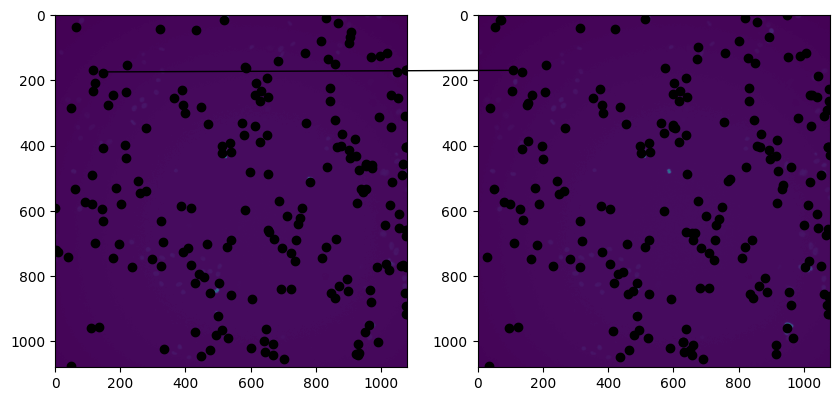

In [181]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

x1 = [cc[0] for cc in cell_centers_0]
y1 = [cc[1] for cc in cell_centers_0]
x2 = [cc[0] for cc in cell_centers_1]
y2 = [cc[1] for cc in cell_centers_1]

ax1.plot(x1,y1,'ko')
ax2.plot(x2,y2,'ko')

i = 20
xy1 = (x1[i],y1[i])
xy2 = (x2[matches[i]],y2[matches[i]])
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1)
ax2.add_artist(con)

#ax1.plot(x1[i],y1[i],'ro',markersize=10)
ax1.imshow(images_1059[0])
#ax2.plot(x2[i],y2[i],'ro',markersize=10)
ax2.imshow(images_1059[1])

plt.show()

In [202]:
print(matches_first_img[5])
print(matches_first_img)
print(matches_second_img)
print(matches_third_img)

8
[0, 5, 9, 6, 7, 8, 9, 9, 10, 9, 10, 13, 14, 14, 16, 17, 16, 19, 20, 20, 22, 28, 28, 22, 28, 28, 24, 39, 22, 40, 27, 30, 22, 33, 32, 33, 36, 39, 36, 49, 39, 40, 45, 44, 55, 46, 49, 50, 56, 62, 61, 0, 55, 61, 56, 59, 62, 61, 63, 62, 63, 61, 68, 78, 70, 71, 68, 72, 81, 62, 72, 78, 78, 75, 68, 64, 85, 72, 84, 85, 85, 85, 85, 85, 88, 87, 88, 0, 89, 87, 92, 100, 95, 102, 102, 89, 102, 98, 111, 100, 94, 100, 103, 104, 105, 106, 0, 101, 105, 109, 104, 111, 112, 113, 114, 124, 110, 110, 118, 118, 120, 119, 120, 118, 124, 124, 132, 126, 128, 131, 129, 139, 133, 132, 0, 135, 137, 135, 124, 137, 137, 138, 139, 132, 141, 142, 149, 138, 138, 142, 142, 143, 142, 147, 149, 150, 149, 151, 152, 166, 157, 154, 155, 157, 169, 152, 160, 164, 160, 164, 157, 169, 171, 174, 169, 175, 176, 176, 178, 179, 175, 180, 182, 182, 183, 179, 175, 195, 192, 0, 189, 195, 192, 193, 194, 183, 193, 195, 196]
[0, 2, 6, 7, 7, 6, 7, 0, 9, 10, 12, 0, 12, 17, 17, 17, 22, 0, 22, 23, 33, 24, 24, 35, 33, 47, 34, 45, 35, 37, 40, 

C:\Users\rz200\AppData\Local\Temp\ipykernel_7912\3428064674.py:27: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(images_1059[3][y4[index]-crop_val:y4[index]+crop_val,x4[index]-crop_val:x4[index]+crop_val])


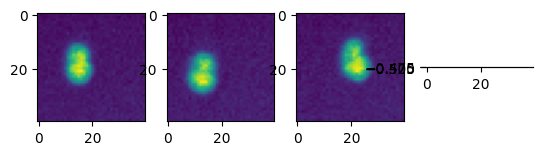

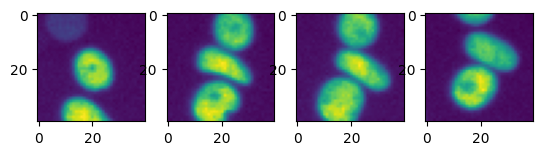

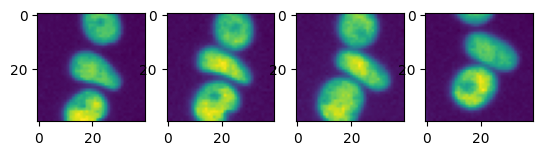

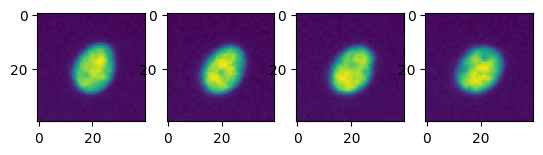

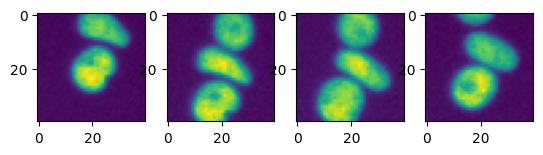

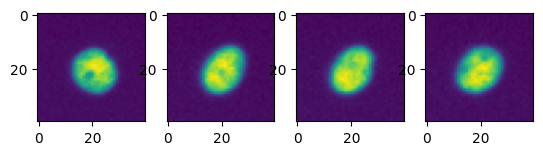

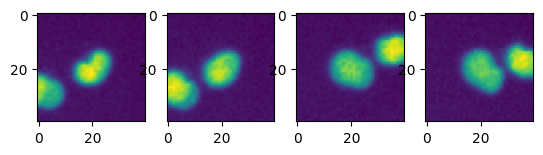

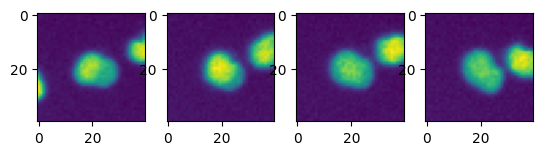

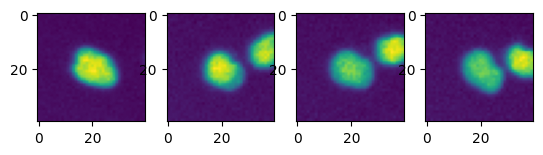

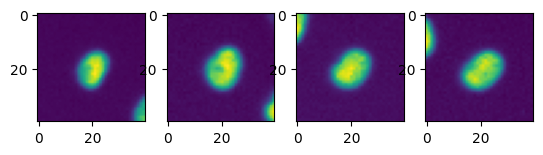

C:\Users\rz200\AppData\Local\Temp\ipykernel_7912\3428064674.py:23: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(images_1059[2][y3[index]-crop_val:y3[index]+crop_val,x3[index]-crop_val:x3[index]+crop_val])


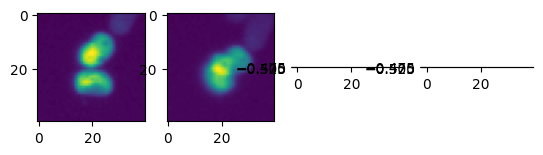

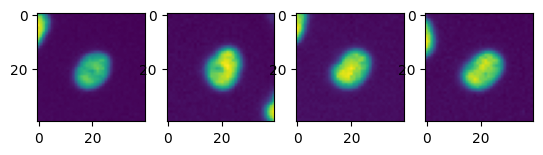

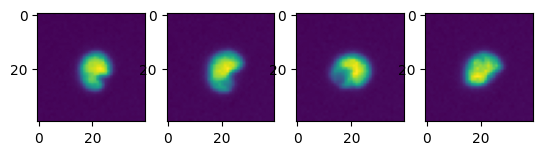

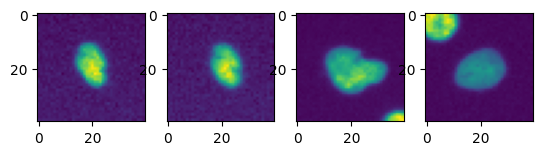

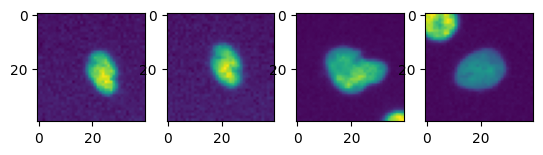

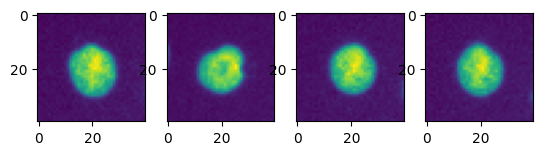

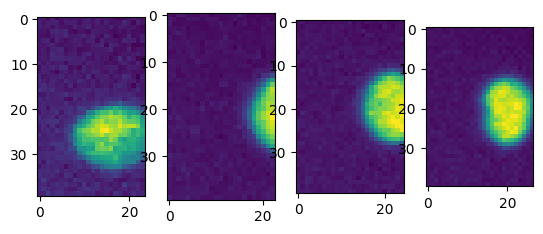

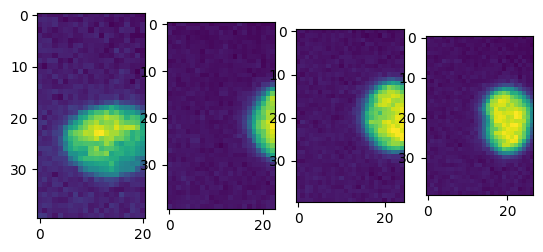

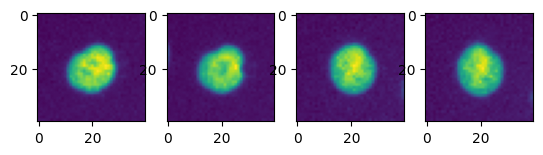

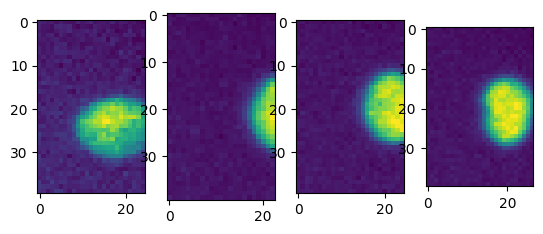

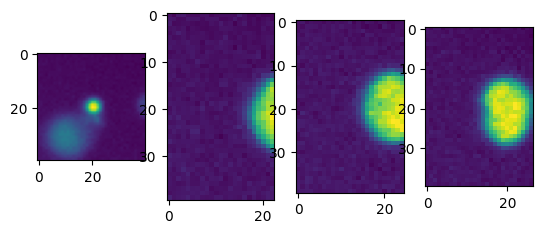

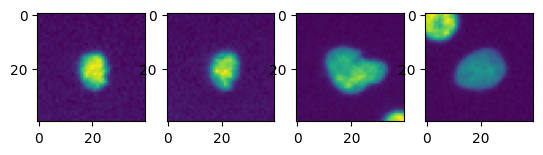

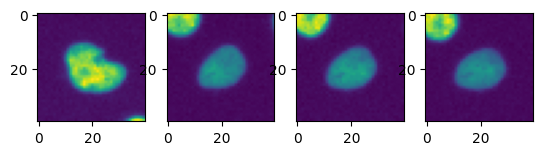

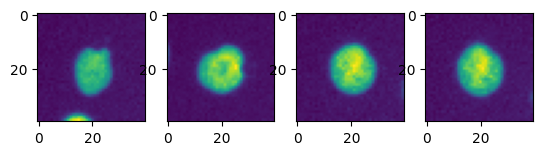

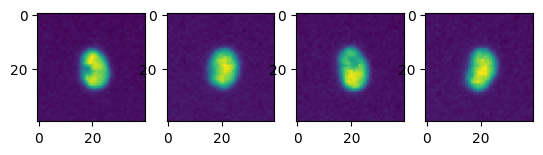

In [205]:
indexes = [i for i in range(5,30)]

x1 = [cc[0] for cc in cell_centers_0]
y1 = [cc[1] for cc in cell_centers_0]
x2 = [cc[0] for cc in cell_centers_1]
y2 = [cc[1] for cc in cell_centers_1]
x3 = [cc[0] for cc in cell_centers_2]
y3 = [cc[1] for cc in cell_centers_2]
x4 = [cc[0] for cc in cell_centers_3]
y4 = [cc[1] for cc in cell_centers_3]

for i in indexes:
    crop_val = 20
    plt.subplot(1,4,1)
    plt.imshow(images_1059[0][y1[i]-crop_val:y1[i]+crop_val,x1[i]-crop_val:x1[i]+crop_val])

    plt.subplot(1,4,2)
    index = matches_first_img[i]
    plt.imshow(images_1059[1][y2[index]-crop_val:y2[index]+crop_val,x2[index]-crop_val:x2[index]+crop_val])

    plt.subplot(1,4,3)
    index = matches_second_img[index]
    plt.imshow(images_1059[2][y3[index]-crop_val:y3[index]+crop_val,x3[index]-crop_val:x3[index]+crop_val])

    plt.subplot(1,4,4)
    index = matches_third_img[index]
    plt.imshow(images_1059[3][y4[index]-crop_val:y4[index]+crop_val,x4[index]-crop_val:x4[index]+crop_val])

    plt.show()

In [42]:
instance_encFeats_0, cell_centers_0 = get_instance_encFeats_from_encFeats(encFeats_cp_flat_0,instance_masks[0],type='cp')

C:\Users\rz200\AppData\Local\Temp\ipykernel_7912\29908231.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(instance_encFeats), cell_centers


In [47]:
import time

start = time.time()
time.sleep(1)
time.time() - start 

1.0062534809112549

In [67]:
res, instance_mask = get_encFeats_flat_from_pred(model,instance_masks[0],encFeats_cps[0])

In [119]:
encFeats_cp_flat_0, cell_centers = get_encFeats_flat_from_pred(model,instance_masks[0],encFeats_cps[0])

instance_encFeats = []
start = time.time()
for i in range(1,max(instance_masks[0].flatten())+1):
    #indexes_of_not_cell = np.squeeze(np.array(np.where(instance_masks[0].flatten()!=i)))
    #print(indexes_of_not_cell.shape)

    #print('ggg',encFeats_cp_flat_0[0].shape,indexes_of_not_cell.shape)
    #rn = np.delete(encFeats_cp_flat_0,indexes_of_not_cell)
    
    #WORKING
    first = instance_masks[0].flatten()
    second = encFeats_cp_flat_0.flatten()
    mask = first == i
    rn = np.take(second, np.where(mask)[0])
    rn = np.extract(rn != 0, rn)

    #print(encFeats_cp_flat_0[0].shape)
    #rn = np.where(instance_masks[0].flatten()!=i,encFeats_cp_flat_0[0].flatten(),0)
    #print(rn)

    instance_encFeats.append(rn)

    
print(time.time()-start)
#cell_centers = get_centers_of_ROIs(instance_masks[0])

1.79819917678833


In [35]:
print(type(encFeats_cps[0][0]))

<class 'torch.Tensor'>


In [33]:
arr = encFeats_cps[0]
arr.shape

AttributeError: 'list' object has no attribute 'detach'

In [ ]:
plt.imshow()

In [70]:
possible_matches = get_matching_cells(first_cell,instance_encFeats_1,distance_between_cells_from_first,radius=200)
print(possible_matches)

[ 1.16496146e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.15337325e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.21657967e-05
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.19487512e-04  0.00000000e+00  0.00000000e+00
  1.41716609e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [48]:
first_cell = instance_encFeats_0[0]

cos_sim_index = get_distance_between_cells(first_cell,instance_encFeats_1)
cell_centers = get_centers_of_ROIs(instance_mask[0])

In [53]:
cos_sim_index.shape

(197,)

In [28]:
cos_sim = instance_encFeats_1[np.argmax(np.dot(instance_encFeats_0[0], instance_encFeats_1.T)/(np.linalg.norm(instance_encFeats_1)*np.linalg.norm(instance_encFeats_0[0])))]

ValueError: shapes (517,) and (197,) not aligned: 517 (dim 0) != 197 (dim 0)